In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Friday 22nd from 9.00h to 11.00h


In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u

In [4]:
from astropy.table import Table, vstack, unique

catalog = Table.read('data/00_base_catalog.fits')

def strip(catalog):  
    drop_cols = []
    keep_cols = ['wd_source_id', 'ms_source_id', 'wd_l', 'wd_b', 'ms_parallax', 'ms_parallax_over_error', 'wd_ra', 'wd_dec', 
                 'wd_bp_rp', 'uses_sdss5']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

catalog  = strip(catalog)

In [5]:
print(len(catalog))

365


In [6]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = (len(catalog)+1000) // 1000

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['ms_source_id'][1000*i:1000*i+1000]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)
gaia_d1.rename_column('source_id', 'ms_source_id')
catalog = join(catalog, gaia_d1, keys = 'ms_source_id')

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [7]:
catalog.remove_column('ms_source_id')

In [8]:
stardats = []
iters = (len(catalog)+1000) // 1000

# This query is for making sure the radii issue isn't a problem with the photometry from the El-Badry catalog (it's not)
for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT source_id, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_flux, phot_bp_mean_flux, phot_rp_mean_flux,
                 phot_g_mean_flux_error, phot_bp_mean_flux_error, phot_rp_mean_flux_error
        FROM gaiadr3.gaia_source     
        WHERE source_id in {}""".format(tuple(catalog['wd_source_id'][1000*i:1000*i+1000]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)
gaia_d1.rename_column('SOURCE_ID', 'source_id')

for key in gaia_d1.keys():
    gaia_d1.rename_column(key, 'wd_' + key)
    
catalog = join(catalog, gaia_d1, keys = 'wd_source_id')

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


In [9]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

# Coordinates using Bailer-Jones distances
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['wd_phot_bp_mean_mag_ext'] = catalog['wd_phot_bp_mean_mag'] - catalog['BP_ext']
catalog['wd_phot_rp_mean_mag_ext'] = catalog['wd_phot_rp_mean_mag'] - catalog['RP_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [10]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed_sdss = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr'])#, 'Si', 'Sz'])
fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr']
initialized with atm_type = H and bands = ['bp', 'rp']


building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


Text(0, 0.5, 'Flux $[erg/s/cm^2/\\AA]$')

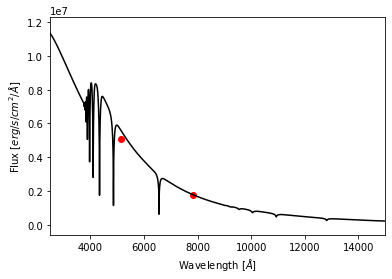

In [11]:
#model_sed = RegularGridInterpolator((teffs, loggs), values)

import pyphot
from pyphot import unit

import corv

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')


lib = pyphot.get_library()
filters = [lib['Gaia_BP'], lib['Gaia_RP']]

fl = tremblay((10000, 8))

wavl = [filters[i].lpivot.to('angstrom').value for i in range(len(filters))]
phot_flux = [filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value for i in range(len(filters))]
phot_mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) \
                     - filters[i].Vega_zero_mag for i in range(len(filters))])

plt.plot(base_wavl, fl, c = 'k')
plt.scatter(wavl, phot_flux, c = 'r')
plt.xlim(2500,15000)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')

In [12]:
import pyphot
from pyphot import unit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

lib = pyphot.get_library()
filters = [#lib['Gaia_G'],
           lib['Gaia_BP'], lib['Gaia_RP']]

In [13]:
def mag_to_flux_spec(mag, filt, e_mag = None):
    if e_mag is not None:
        return (10**( (mag + filt.Vega_zero_mag) / -2.5 ), np.sqrt((-0.921034 * 10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)**2 ))
    else:
        return 10**( (mag + filt.Vega_zero_mag) / -2.5 )

def template(teff, logg, radius, distance):
    fl = tremblay((teff, logg))
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = 4*np.pi*(radius / distance)**2 * fl
    return fl
    

def get_model_flux_gaia_spec(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([filters[i].get_flux(base_wavl * unit['angstrom'], fl * unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(filters))])
    #mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) - filters[i].Vega_zero_mag for i in range(len(filters))])
    return flux
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux_gaia_spec(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

def get_parameters_gaia(obs_flux, e_obs_flux, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    #e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 4001, max = 35000, vary = True)
    params.add('logg', value = p0[1], min=5, max=9, vary=False)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
            
    #result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'emcee', steps = 500, burn = 250, thin = 20, is_weighted = True, float_behavior = 'chi2', progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [15]:
plt.style.use('stefan.mplstyle')

gaia_results = []
gaia_results7 = []
gaia_results9 = []

reference_results = []
reference_results7 = []
reference_results9 = []


e_results = []

drops = []

logg_vary = []

id_ = []

bands = ['bp', 'rp']

for i in tqdm(range(len(catalog))):
    # Convert Gaia flux into f_lam using table 5.3 
    # https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photProc/cu5pho_ssec_photCal.html    
    
    obs_flux_ext = np.array([mag_to_flux_spec(catalog['wd_phot_bp_mean_mag_ext'][i], filters[0]),
                         mag_to_flux_spec(catalog['wd_phot_rp_mean_mag_ext'][i], filters[1])])
    
    obs_flux = np.array([mag_to_flux_spec(catalog['wd_phot_bp_mean_mag'][i], filters[0]),
                         mag_to_flux_spec(catalog['wd_phot_rp_mean_mag'][i], filters[1])])
    e_obs_flux = np.array([#catalog['wd_phot_g_mean_flux_error'][i] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2 , 
                           catalog['wd_phot_bp_mean_flux_error'][i] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2, 
                           catalog['wd_phot_rp_mean_flux_error'][i] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2])
        
    #try:    
    gaia_logg7_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_med_geo'][i]] )
    gaia_logg8_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_med_geo'][i]] )
    gaia_logg9_ext = get_parameters_gaia( obs_flux_ext, e_obs_flux, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_med_geo'][i]] )
    id_.append(i)
    
    gaia_results.append(gaia_logg8_ext)
    gaia_results7.append(gaia_logg7_ext)
    gaia_results9.append(gaia_logg9_ext)
    #except:
    #    drops.append(i)
        
    
    #reference_results.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_med_geo'][i]]))
    #reference_results7.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_med_geo'][i]]))
    #reference_results9.append(get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_med_geo'][i]]))

    
    fig = plt.figure(figsize = (8,7))
        
    #plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    #plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], get_model_flux_gaia(gaia_logg8.params), 'bo', markersize = 10, label = 'Model SED')
    
    plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux_ext, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], get_model_flux_gaia_spec(gaia_logg8_ext.params), 'bo', markersize = 10, label = 'Model SED')
    
    model_fl = template(gaia_logg8_ext.params['teff'].value, gaia_logg8_ext.params['logg'].value, gaia_logg8_ext.params['radius'].value, gaia_logg8_ext.params['distance'].value)
    mask = (3600 < base_wavl)*(base_wavl<9000)
    plt.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
    
    
    #model_fl = template(gaia_logg8.params['teff'].value, gaia_logg8.params['logg'].value, gaia_logg8.params['radius'].value, gaia_logg8.params['distance'].value)
    #mask = (3600 < base_wavl)*(base_wavl<9000)
    #plt.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')
    
    #plt.ylim(0.1*min(model_fl[mask]), 1.1*max(model_fl[mask]))
    
    #plt.title('SED {}'.format(i))
    
    plt.text(0.05, 0.20, "$T_{eff}$" + " = {:2.6} $K$".format(gaia_logg8_ext.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.15, "$\log g$" + " = {:2.5f}".format(gaia_logg8_ext.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.05, '$Distance = ${:2.1f} $pc$'.format(gaia_logg8_ext.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
    plt.text(0.05, 0.10, r'$Radius = ${:2.5f} $R_\odot$'.format(gaia_logg8_ext.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.80, 0.05, r'$\chi_r^2 = ${:2.2f}'.format(gaia_logg8_ext.redchi), transform = plt.gca().transAxes, fontsize = 18)
    
    plt.xlim((3600, 9000))
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
        
    
    #plt.gca().invert_yaxis()
    plt.legend(framealpha = 0) 
    plt.savefig('figures/photo/{}.png'.format(i))
    plt.close()
    
    #print(gaia_logg8.params['radius'].stderr)
    
    #fig = plt.figure(figsize = (8,7))
    
    #plt.errorbar([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
    #model_mag = get_model_flux_gaia(gaia_logg8.params)
    #plt.plot([filters[j].lpivot.to('angstrom').value for j in range(len(filters))], [mag_to_flux_spec(model_mag[i], filters[i]) for i in range(len(filters))], 'bo', markersize = 10, label = 'Model SED (Color Tables)')
    
    
    
    #plt.xlim((3600, 9000))
    #plt.xlabel(r'Wavelength $[\AA]$')
    #plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
    
    #plt.legend(framealpha = 0) 
    #plt.show()
    
print('dropped {} stars'.format(len(drops)))
catalog.remove_rows(drops)
catalog['wd_catalog_id_phot'] = id_
results = gaia_results

100%|██████████| 365/365 [12:20<00:00,  2.03s/it]

dropped 0 stars


In [16]:
catalog['raw_radius_result'] = [result for result in gaia_results]
catalog['radius'] = [result.params['radius'].value for result in gaia_results]
catalog['phot_teff'] = [result.params['teff'].value for result in gaia_results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in gaia_results]
catalog['redchi'] = [result.redchi for result in gaia_results]
catalog['e_radius'] = [np.sqrt(gaia_results[i].params['radius'].stderr**2 + np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value)**2 ) for i in range(len(gaia_results))]
catalog['error_from_model'] = [np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value) for i in range(len(gaia_results))]

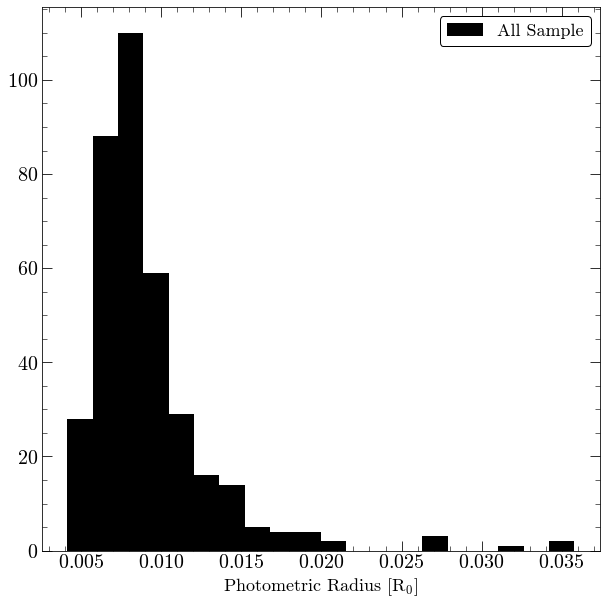

In [18]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

In [21]:
catalog.remove_columns(['ms_parallax', 'wd_l', 'wd_b', 'raw_radius_result', 'wd_bp_rp', 'wd_phot_g_mean_mag', 'e_phot_teff',
                        'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error'])

catalog.write('data/02_photometry.fits', overwrite=True)

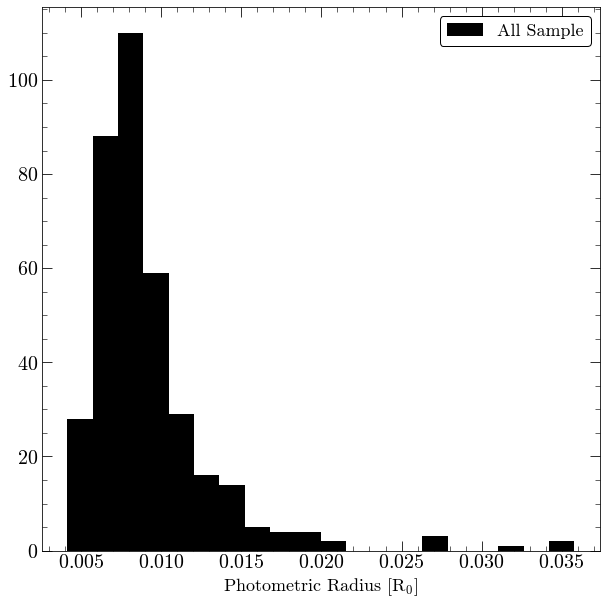

In [34]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

In [27]:
catalog.keys()

['wd_source_id',
 'ms_parallax_over_error',
 'wd_ra',
 'wd_dec',
 'r_med_geo',
 'wd_phot_g_mean_flux',
 'wd_phot_bp_mean_flux',
 'wd_phot_rp_mean_flux',
 'wd_coords',
 'E(B-V)',
 'e_E(B-V)',
 'A_v0',
 'BP_ext',
 'RP_ext',
 'wd_phot_bp_mean_mag_ext',
 'wd_phot_rp_mean_mag_ext',
 'wd_catalog_id_phot',
 'radius',
 'phot_teff',
 'redchi',
 'e_radius',
 'error_from_model']

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-56-34d239145fbb>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-56-34d239145fbb>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-56-34d239145fbb>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


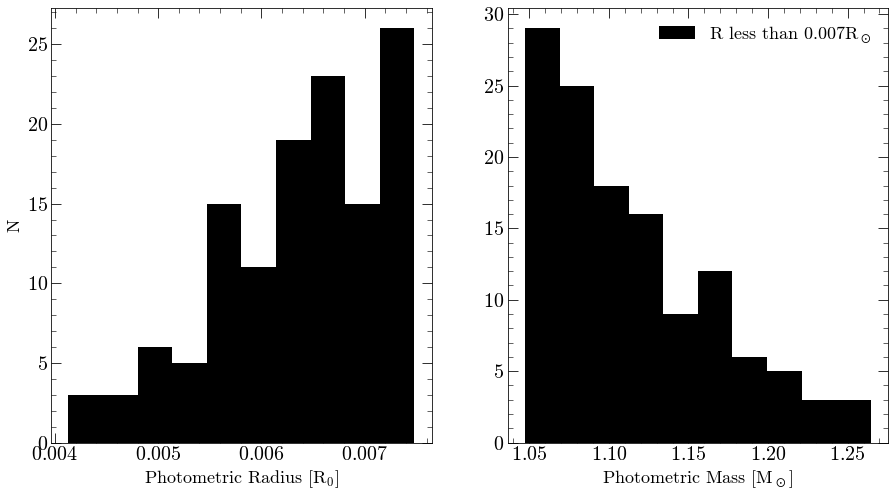

In [56]:
def mass_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'o'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun

    return mass / mass_sun



plt.figure(figsize=(15,8))

plt.subplot(1,2,1)

plt.hist(catalog[catalog['radius'] < 0.0075]['radius'], bins = 10, color='black')#, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.ylabel('N', fontsize = 18)

plt.subplot(1,2,2)
plt.hist(mass_from_radius(catalog[catalog['radius'] < 0.0075]['radius'], catalog[catalog['radius'] < 0.0075]['phot_teff']), bins = 10, color='black', label = r'$R$ less than $0.007 R_\odot$')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Mass $[M_\odot]$', fontsize=18)
plt.legend(framealpha = 0)

In [58]:
catalog = catalog[catalog['radius'] < 0.0075]

catalog.write('data/02_photometry.fits', overwrite=True)